In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
import csv

2024-12-11 19:09:22.047826: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733911762.203156 4169159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733911762.255677 4169159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 19:09:22.637395: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
with open("dataset/ptbxl_database.csv", 'r') as raw_ptbxl_fp:
    with open("dataset/scp_statements.csv", 'r') as raw_stmts_fp:
        raw_ptbxl_csv = csv.DictReader(raw_ptbxl_fp)
        raw_stmts_csv = csv.DictReader(raw_stmts_fp)

        lst_ptbxl = []
        lst_stmts = []

        for i in raw_ptbxl_csv:
            lst_ptbxl.append(i)

        for i in raw_stmts_csv:
            lst_stmts.append(i)

        stmt_dict = dict()
        lst_out = []

        for i in lst_stmts:
            stmt_dict[i['']] = i['diagnostic_class']

        for i in lst_ptbxl:
            if i['scp_codes'].count('NORM'):
                lst_out.append([0, i['filename_lr'].split('.')[0], i['strat_fold']])
            else:
                lst_out.append([1, i['filename_lr'].split('.')[0], i['strat_fold']])

        header = ['class', 'fname', 'fold']

        with open('dataset/label.csv', 'w') as outfp:
            writer = csv.writer(outfp)
            writer.writerow(header)
            writer.writerows(lst_out)

In [3]:
tmp_y = pd.read_csv('dataset/label.csv')
X = np.array([wfdb.rdsamp('dataset/' + f)[0] for f in tmp_y.fname])

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [4]:
Y = []
for i in tmp_y[['class']].values:
    # NORM, MI(STEMI), STTC(NSTEMI), CD(부정맥), HYP(비대), ETC
    if i[0] == 0: # 정상(NORM)
        Y.append(0)
    else: # 비정상(ETCs)
        Y.append(1)
Y = np.array(Y)

print(Y.shape)

(21799,)


In [6]:
X = tf.cast(X, tf.float32)
print(X.shape)

(21799, 1000, 12)


## PrettyBatch 128

In [ ]:
model_pretty = tf.keras.Sequential([
    # 1D Convolutional Layer
    layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # LSTM Layers
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Dense Layers
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.25),
    
    layers.Dense(1, activation='sigmoid')
])

model_pretty.summary()
model_pretty.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy'])

record_pretty_batch128 = model_pretty.fit(X, Y,
                   epochs=28,
                   batch_size=128,
                   validation_split=0.2,
                   shuffle=True)

model_pretty.save("pretty-batch128.keras")

fig, ax = plt.subplots()
plt.plot(record_pretty_batch128.history['loss'], label='Training Loss')
plt.plot(record_pretty_batch128.history['val_loss'], label='Validation Loss')
plt.legend()
plt.suptitle('Loss')
plt.show()

plt.plot(record_pretty_batch128.history['accuracy'], label='Training Accuracy')
plt.plot(record_pretty_batch128.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.suptitle('Accuracy')
plt.show()

## 20Epoch Overfit

In [ ]:
model = tf.keras.Sequential([
    # 1D Convolutional Layer
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.3),

    # LSTM Layers
    layers.LSTM(64, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Bidirectional(layers.LSTM(32, return_sequences=False)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # Dense Layers
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(1, activation='sigmoid')
])

model.summary()
model.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy'])

record = model.fit(X, Y,
                   epochs=26,
                   batch_size=128,
                   validation_split=0.2,
                   shuffle=True)

model.save("algorithm2.keras")

fig, ax = plt.subplots()
plt.plot(record.history['loss'], label='Training Loss')
plt.plot(record.history['val_loss'], label='Validation Loss')
plt.legend()
plt.suptitle('Loss')
plt.show()

plt.plot(record.history['accuracy'], label='Training Accuracy')
plt.plot(record.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.suptitle('Accuracy')
plt.show()

## Evaluating

In [ ]:
chunks = []

with open('dataset/label.csv') as fp:
    rdr = csv.reader(fp)
    next(rdr)

    row_count = sum(1 for row in rdr)
    fp.seek(0)
    next(rdr)

    tmplst = []

    for row in rdr:
        tmplst.append(row)

    for i in range(1, 11):
        chunks.append([])
        for j in range(row_count):
            if int(tmplst[j][2]) == i:
                chunks[i - 1].append(tmplst[j])

for i in range(1, 11):
    with open('dataset/strat_fold-' + str(i) + '.csv', 'w') as fp:
        wtr = csv.writer(fp)

        header = ['class', 'fname', 'fold']
        wtr.writerow(header)
        wtr.writerows(chunks[i - 1])

### For ANOVA

In [ ]:
for j in range(1, 11, 2):
    tmp_y = pd.concat([pd.read_csv('dataset/strat_fold-' + str(j) + '.csv'), pd.read_csv('dataset/strat_fold-' + str(j + 1) + '.csv')])
    X = np.array([wfdb.rdsamp('dataset/' + f)[0] for f in tmp_y.fname])

    Y = []
    for i in tmp_y[['class']].values:
        # NORM, MI(STEMI), STTC(NSTEMI), CD(부정맥), HYP(비대), ETC
        if i[0] == 0: # 정상(NORM)
            Y.append(0)
        else: # 비정상(ETCs)
            Y.append(1)

    Y = np.array(Y)
    X = tf.cast(X, tf.float32)

    loss, acc = model1.evaluate(X, Y)
    print(f"# ----- #")
    print(f"Model 1. Loss = {loss}, Acc = {acc}")
    loss, acc = model2.evaluate(X, Y)
    print(f"Model 2. Loss = {loss}, Acc = {acc}")

## Last Evaluate

In [ ]:
tmp_y = pd.read_csv('dataset/label.csv')
X = np.array([wfdb.rdsamp('dataset/' + f)[0] for f in tmp_y.fname])
Y = []
for i in tmp_y[['class']].values:
    # NORM, MI(STEMI), STTC(NSTEMI), CD(부정맥), HYP(비대), ETC
    if i[0] == 0: # 정상(NORM)
        Y.append(0)
    else: # 비정상(ETCs)
        Y.append(1)
Y = np.array(Y)

In [ ]:
X = tf.cast(X, tf.float32)

In [ ]:
model = load_model("pretty-batch128.keras")

In [ ]:
from sklearn.metrics import confusion_matrix

y_prediction = model.predict(X)

result = confusion_matrix(Y, np.where(y_prediction > 0.5, 1, 0))
print(result)

In [ ]:
print(Y.shape)

   class                      fname  fold
0      0  records100/00000/00001_lr     3


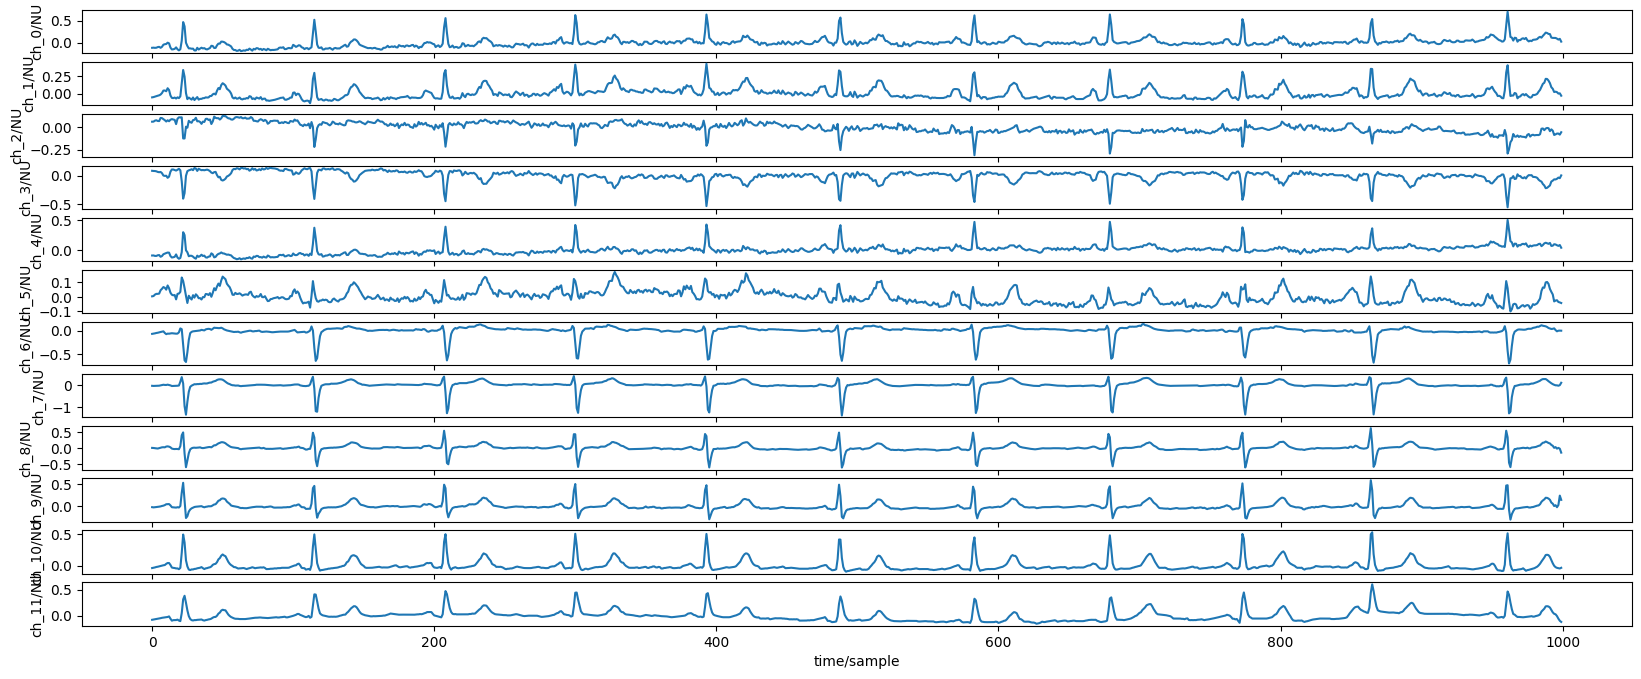

In [109]:
fileidx = input("ECG 번호 입력(00000 Format): ") + '_lr'

tmp_y = pd.read_csv('dataset/label.csv') # 01111_lr -> 1, 00010 -> 0
file = tmp_y['fname'].str.contains(fileidx)
subdf = tmp_y[file]

print(subdf)
record = wfdb.rdrecord('dataset/' + subdf.iloc[0,1])
wfdb.plot_items(signal=record.p_signal, figsize=(20, 8))

In [107]:
X = np.array([wfdb.rdsamp('dataset/' + f)[0] for f in subdf.fname])
Y = []
for i in tmp_y[['class']].values:
    # NORM, MI(STEMI), STTC(NSTEMI), CD(부정맥), HYP(비대), ETC
    if i[0] == 0: # 정상(NORM)
        Y.append(0)
    else: # 비정상(ETCs)
        Y.append(1)
Y = np.array(Y)
print("NORM" if np.where(model.predict(X) > 0.5, 1, 0)[0][0] == 0 else "ANOM")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
NORM
